### Επίδραση του Αριθμού των Δωρεάν Αδειών στα Κέρδη και άλλες Μεταβλητές των Επιχειρήσεων

**Πείραμα:**
- Emission cap = 70%, 80%, 90% BAU emissions
- 9 εταιρείες
- 3 τομείς
  - Ο 3ος τομέας έχει **πολύ μεγάλο** μέγεθος σε όρους πωλήσεων

**Διαδικασία:**
Δίνουμε σταδιακά περισσότερες δωρεάν άδειες **σε όλους** και το συγκρίνουμε με το να έπαιρναν **τα μισά** οι άλλοι δύο τομείς.

- Δωρεάν άδειες: από 0 έως την ποσότητα παραγωγής (q).


In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from funkwpap import *
import sympy as sp, pandas as pd, numpy as np, tqdm, time, sys, matplotlib.pyplot as plt, tqdm
from statistics import mean
from scipy.optimize import fsolve
from random import random


In [2]:
x = sp.symbols('x')
cap = 2000 # total emission cap
Regulator25 = Regulator("test1", permit_price = 2.4079, emission_cap = cap)
sector1 = Sector('cement', price_demand_function= 100 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator25)
sector2 = Sector('steel', price_demand_function=150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator25)
sector3 = Sector('paper', price_demand_function= 200 - 0.02*x**1.5, free_emission_multiplier= 0, regulator= Regulator25)
country1 = Country('DE', 1, regulator= Regulator25)
country2 = Country('FI', 0.5, regulator= Regulator25)
country3 = Country('GR', size= 0.1, regulator= Regulator25)

# Create Firms using objects
firm1 = Firm('firm1', 1, 1, x*0, 2*x+ 2*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator25)
firm2 = Firm('firm2', 1, 2, x*0, 3*x+ 3*x**2 + 2*x**3, 0, 0, 0, regulator= Regulator25)
firm3 = Firm('firm3', 1, 3, x*0, 1*x+ 3*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator25)
firm4 = Firm('firm4', 2, 1, x*0, 7*x+ 5*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator25)
firm5 = Firm('firm5', 2, 2, x*0, 1*x+ 6*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator25)
firm6 = Firm('firm6', 2, 3, x*0, 2*x+ 7*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator25)
firm7 = Firm('firm7', 3, 1, x*0, 3*x+ 8*x**2 + 4*x**3 , 0, 0, 0, regulator= Regulator25)
firm8 = Firm('firm8', 3, 2, x*0, 4*x+ 9*x**2 + 10*x**3 , 0, 0, 0, regulator= Regulator25)
firm9 = Firm('firm9', 3, 3, x*0, 5*x+ 10*x**2 + 11*x**3 , 0, 0, 0, regulator= Regulator25)



In [3]:
Regulator25.BAU_calculator()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-14


In [4]:
# Define the percentages of BAU emissions
do_all_get_free = [False, True]
Regulator25.emission_cap = Regulator25.BAU_emissions * 0.8
# Initialize dictionaries to store results for each percentage
results = {do: {
    'profits1': [], 'profits2': [], 'abatements1': [], 'abatements2': [],
    'trades1': [], 'trades2': [], 'permits_bought_1': [], 'permits_bought_2': [],
    'permits_free_1': [], 'permits_free_2': [], 'permits_used_1': [], 'permits_used_2': [],
    'revenews1': [], 'revenews2': [], 'permit_price': [],
    'outputs1': [], 'outputs2': [], 'emissions1': [], 'emissions2': [],
    'consumer_surplus_1' : [], 'consumer_surplus_2' : []
} for do in do_all_get_free}

# Loop over each percentage
for do in do_all_get_free:
    Regulator25.emission_cap = Regulator25.BAU_emissions * 0.8
    frees = np.linspace(0, 1, 100)

    for free in tqdm.tqdm(frees):
        sector1.free_emission_multiplier = free
        if do:
            sector2.free_emission_multiplier = free*0.5
            sector3.free_emission_multiplier = free*0.5
        else:
            sector2.free_emission_multiplier = 0
            sector3.free_emission_multiplier = 0
        Regulator25.optimization_concave_formulation_ab()
        # Regulator25.optimization_with_least_squares_ab()
        Regulator25.equilibrium_tester(precision = 0.1, output=True)

        for firm in Regulator25.firm_registry.values():
            firm.calculate_profit_components()

        results[do]['profits1'].append(mean(float(i.profit) for i in sector1.firms))
        results[do]['profits2'].append(mean(float(i.profit) for i in sector2.firms + sector3.firms))
        results[do]['abatements1'].append(mean(float(i.abatement) for i in sector1.firms))
        results[do]['abatements2'].append(mean(float(i.abatement) for i in sector2.firms + sector3.firms))
        results[do]['trades1'].append(mean(float(i.permits_costs) for i in sector1.firms))
        results[do]['trades2'].append(mean(float(i.permits_costs) for i in sector2.firms + sector3.firms))
        results[do]['revenews1'].append(mean(float(i.sales) for i in sector1.firms))
        results[do]['revenews2'].append(mean(float(i.sales) for i in sector2.firms + sector3.firms))
        results[do]['permit_price'].append(Regulator25.permit_price)
        results[do]['outputs1'].append(mean(float(i.actual_output) for i in sector1.firms))
        results[do]['outputs2'].append(mean(float(i.actual_output) for i in sector2.firms + sector3.firms))
        results[do]['emissions1'].append(mean(float(i.emission) for i in sector1.firms))
        results[do]['emissions2'].append(mean(float(i.emission) for i in sector2.firms + sector3.firms))
        results[do]['consumer_surplus_1'].append(sector1.get_consumer_surplus())
        results[do]['consumer_surplus_2'].append((sector2.get_consumer_surplus() + sector3.get_consumer_surplus())/2)
        results[do]['permits_used_1'].append(mean( float(i.permits_used) for i in sector1.firms))
        results[do]['permits_used_2'].append(mean( float(i.permits_used) for i in sector2.firms + sector3.firms))
        results[do]['permits_free_1'].append(mean( float(i.free_permits) for i in sector1.firms))
        results[do]['permits_free_2'].append(mean( float(i.free_permits) for i in sector2.firms + sector3.firms))
        results[do]['permits_bought_1'].append(mean( float(i.permits_bought) for i in sector1.firms))
        results[do]['permits_bought_2'].append(mean( float(i.permits_bought) for i in sector2.firms + sector3.firms))



  0%|          | 0/100 [00:00<?, ?it/s]

Optimal solution found


  1%|          | 1/100 [00:03<06:04,  3.68s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0818 ✔️ |  +4.61e-6 ✔️ |  -24.6315 ✔️ |  -24.8315 ✔️ |   +4.9263 ✔️ | 5/5
Optimal solution found


  2%|▏         | 2/100 [00:07<05:45,  3.53s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0807 ✔️ | +7.06e-10 ✔️ |  -24.6916 ✔️ |  -24.8916 ✔️ |   +4.9383 ✔️ | 5/5
Optimal solution found


  3%|▎         | 3/100 [00:10<05:36,  3.47s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0796 ✔️ |  +2.81e-5 ✔️ |  -24.7521 ✔️ |  -24.9521 ✔️ |   +4.9504 ✔️ | 5/5
Optimal solution found


  4%|▍         | 4/100 [00:14<05:43,  3.58s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0785 ✔️ |  +2.85e-5 ✔️ |  -24.8130 ✔️ |  -25.0130 ✔️ |   +4.9626 ✔️ | 5/5
Optimal solution found


  5%|▌         | 5/100 [00:17<05:43,  3.61s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0773 ✔️ |  +1.72e-5 ✔️ |  -24.8743 ✔️ |  -25.0743 ✔️ |   +4.9749 ✔️ | 5/5
Optimal solution found


  6%|▌         | 6/100 [00:21<05:44,  3.66s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0762 ✔️ |  +3.19e-5 ✔️ |  -24.9360 ✔️ |  -25.1360 ✔️ |   +4.9872 ✔️ | 5/5
Optimal solution found


  7%|▋         | 7/100 [00:25<05:36,  3.62s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0749 ✔️ |  +8.37e-6 ✔️ |  -24.9982 ✔️ |  -25.1982 ✔️ |   +4.9996 ✔️ | 5/5
Optimal solution found


  8%|▊         | 8/100 [00:28<05:16,  3.44s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0737 ✔️ |  +2.86e-5 ✔️ |  -25.0607 ✔️ |  -25.2607 ✔️ |   +5.0121 ✔️ | 5/5
Optimal solution found


  9%|▉         | 9/100 [00:31<04:59,  3.29s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0724 ✔️ |  +1.32e-5 ✔️ |  -25.1238 ✔️ |  -25.3238 ✔️ |   +5.0248 ✔️ | 5/5
Optimal solution found


 10%|█         | 10/100 [00:34<04:54,  3.27s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0711 ✔️ |  +1.40e-5 ✔️ |  -25.1873 ✔️ |  -25.3873 ✔️ |   +5.0375 ✔️ | 5/5
Optimal solution found


 11%|█         | 11/100 [00:38<05:18,  3.58s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0697 ✔️ |  +2.42e-6 ✔️ |  -25.2512 ✔️ |  -25.4512 ✔️ |   +5.0502 ✔️ | 5/5
Optimal solution found


 12%|█▏        | 12/100 [00:41<04:56,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0702 ✔️ |  +9.75e-6 ✔️ |  -25.3156 ✔️ |  -25.5156 ✔️ |   +5.0631 ✔️ | 5/5
Optimal solution found


 13%|█▎        | 13/100 [00:45<04:54,  3.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0670 ✔️ |  +2.82e-5 ✔️ |  -25.3804 ✔️ |  -25.5804 ✔️ |   +5.0761 ✔️ | 5/5
Optimal solution found


 14%|█▍        | 14/100 [00:48<04:46,  3.33s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0655 ✔️ |  +1.31e-5 ✔️ |  -25.4458 ✔️ |  -25.6458 ✔️ |   +5.0892 ✔️ | 5/5
Optimal solution found


 15%|█▌        | 15/100 [00:51<04:43,  3.33s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0641 ✔️ |  +1.03e-5 ✔️ |  -25.5116 ✔️ |  -25.7116 ✔️ |   +5.1023 ✔️ | 5/5
Optimal solution found


 16%|█▌        | 16/100 [00:55<04:52,  3.48s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0626 ✔️ |  +2.09e-5 ✔️ |  -25.5778 ✔️ |  -25.7778 ✔️ |   +5.1156 ✔️ | 5/5
Optimal solution found


 17%|█▋        | 17/100 [00:58<04:35,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0610 ✔️ |  +1.23e-5 ✔️ |  -25.6446 ✔️ |  -25.8446 ✔️ |   +5.1289 ✔️ | 5/5
Optimal solution found


 18%|█▊        | 18/100 [01:01<04:30,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0594 ✔️ |  +1.19e-5 ✔️ |  -25.7118 ✔️ |  -25.9118 ✔️ |   +5.1424 ✔️ | 5/5
Optimal solution found


 19%|█▉        | 19/100 [01:04<04:23,  3.25s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0590 ✔️ |  +1.77e-5 ✔️ |  -25.7796 ✔️ |  -25.9796 ✔️ |   +5.1559 ✔️ | 5/5
Optimal solution found


 20%|██        | 20/100 [01:08<04:41,  3.52s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0562 ✔️ |  +8.63e-6 ✔️ |  -25.8478 ✔️ |  -26.0478 ✔️ |   +5.1696 ✔️ | 5/5
Optimal solution found


 21%|██        | 21/100 [01:12<04:41,  3.57s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0545 ✔️ |  +3.36e-6 ✔️ |  -25.9166 ✔️ |  -26.1166 ✔️ |   +5.1833 ✔️ | 5/5
Optimal solution found


 22%|██▏       | 22/100 [01:16<04:37,  3.55s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0527 ✔️ |  +4.78e-6 ✔️ |  -25.9859 ✔️ |  -26.1859 ✔️ |   +5.1972 ✔️ | 5/5
Optimal solution found


 23%|██▎       | 23/100 [01:19<04:29,  3.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0510 ✔️ |  +2.57e-5 ✔️ |  -26.0557 ✔️ |  -26.2557 ✔️ |   +5.2111 ✔️ | 5/5
Optimal solution found


 24%|██▍       | 24/100 [01:22<04:23,  3.47s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0491 ✔️ |  +3.36e-6 ✔️ |  -26.1260 ✔️ |  -26.3260 ✔️ |   +5.2252 ✔️ | 5/5
Optimal solution found


 25%|██▌       | 25/100 [01:26<04:20,  3.47s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0473 ✔️ |  +2.28e-5 ✔️ |  -26.1968 ✔️ |  -26.3968 ✔️ |   +5.2394 ✔️ | 5/5
Optimal solution found


 26%|██▌       | 26/100 [01:29<04:12,  3.42s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0454 ✔️ |  +1.74e-5 ✔️ |  -26.2683 ✔️ |  -26.4683 ✔️ |   +5.2537 ✔️ | 5/5
Optimal solution found


 27%|██▋       | 27/100 [01:33<04:15,  3.51s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0434 ✔️ |  +2.48e-5 ✔️ |  -26.3402 ✔️ |  -26.5402 ✔️ |   +5.2680 ✔️ | 5/5
Optimal solution found


 28%|██▊       | 28/100 [01:36<04:10,  3.47s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0414 ✔️ |  +2.33e-5 ✔️ |  -26.4127 ✔️ |  -26.6127 ✔️ |   +5.2825 ✔️ | 5/5
Optimal solution found


 29%|██▉       | 29/100 [01:40<04:15,  3.60s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0393 ✔️ |  +8.68e-6 ✔️ |  -26.4858 ✔️ |  -26.6858 ✔️ |   +5.2972 ✔️ | 5/5
Optimal solution found


 30%|███       | 30/100 [01:44<04:26,  3.80s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0372 ✔️ |  +8.94e-6 ✔️ |  -26.5595 ✔️ |  -26.7595 ✔️ |   +5.3119 ✔️ | 5/5
Optimal solution found


 31%|███       | 31/100 [01:47<04:06,  3.57s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0351 ✔️ |  +2.98e-5 ✔️ |  -26.6337 ✔️ |  -26.8337 ✔️ |   +5.3267 ✔️ | 5/5
Optimal solution found


 32%|███▏      | 32/100 [01:51<04:01,  3.56s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0329 ✔️ |  +2.76e-5 ✔️ |  -26.7085 ✔️ |  -26.9085 ✔️ |   +5.3417 ✔️ | 5/5
Optimal solution found


 33%|███▎      | 33/100 [01:55<04:05,  3.66s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0306 ✔️ |  +3.19e-5 ✔️ |  -26.7839 ✔️ |  -26.9839 ✔️ |   +5.3568 ✔️ | 5/5
Optimal solution found


 34%|███▍      | 34/100 [01:58<04:00,  3.64s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0283 ✔️ |  +3.05e-5 ✔️ |  -26.8600 ✔️ |  -27.0600 ✔️ |   +5.3720 ✔️ | 5/5
Optimal solution found


 35%|███▌      | 35/100 [02:02<03:46,  3.48s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0259 ✔️ |  +2.10e-5 ✔️ |  -26.9366 ✔️ |  -27.1366 ✔️ |   +5.3873 ✔️ | 5/5
Optimal solution found


 36%|███▌      | 36/100 [02:05<03:35,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0235 ✔️ |  +6.74e-6 ✔️ |  -27.0139 ✔️ |  -27.2139 ✔️ |   +5.4028 ✔️ | 5/5
Optimal solution found


 37%|███▋      | 37/100 [02:08<03:35,  3.42s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0211 ✔️ |  +2.90e-5 ✔️ |  -27.0917 ✔️ |  -27.2917 ✔️ |   +5.4183 ✔️ | 5/5
Optimal solution found


 38%|███▊      | 38/100 [02:11<03:25,  3.31s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0185 ✔️ |  +1.05e-5 ✔️ |  -27.1703 ✔️ |  -27.3703 ✔️ |   +5.4341 ✔️ | 5/5
Optimal solution found


 39%|███▉      | 39/100 [02:15<03:33,  3.51s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0159 ✔️ |  +1.17e-6 ✔️ |  -27.2494 ✔️ |  -27.4494 ✔️ |   +5.4499 ✔️ | 5/5
Optimal solution found


 40%|████      | 40/100 [02:19<03:33,  3.56s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0132 ✔️ |  +1.51e-5 ✔️ |  -27.3293 ✔️ |  -27.5293 ✔️ |   +5.4659 ✔️ | 5/5
Optimal solution found


 41%|████      | 41/100 [02:23<03:36,  3.67s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0105 ✔️ |  +1.97e-5 ✔️ |  -27.4098 ✔️ |  -27.6098 ✔️ |   +5.4820 ✔️ | 5/5
Optimal solution found


 42%|████▏     | 42/100 [02:26<03:29,  3.61s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0076 ✔️ |  +2.13e-5 ✔️ |  -27.4909 ✔️ |  -27.6909 ✔️ |   +5.4982 ✔️ | 5/5
Optimal solution found


 43%|████▎     | 43/100 [02:30<03:24,  3.58s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0048 ✔️ |  +2.15e-5 ✔️ |  -27.5728 ✔️ |  -27.7728 ✔️ |   +5.5146 ✔️ | 5/5
Optimal solution found


 44%|████▍     | 44/100 [02:33<03:15,  3.49s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0018 ✔️ |  +3.02e-6 ✔️ |  -27.6553 ✔️ |  -27.8553 ✔️ |   +5.5311 ✔️ | 5/5
Optimal solution found


 45%|████▌     | 45/100 [02:37<03:20,  3.64s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0012 ✔️ |  +3.66e-6 ✔️ |  -27.7386 ✔️ |  -27.9386 ✔️ |   +5.5477 ✔️ | 5/5
Optimal solution found


 46%|████▌     | 46/100 [02:40<03:10,  3.53s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0043 ✔️ |  +2.68e-5 ✔️ |  -27.8225 ✔️ |  -28.0225 ✔️ |   +5.5645 ✔️ | 5/5
Optimal solution found


 47%|████▋     | 47/100 [02:43<02:57,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0075 ✔️ |  +2.77e-5 ✔️ |  -27.9072 ✔️ |  -28.1072 ✔️ |   +5.5814 ✔️ | 5/5
Optimal solution found


 48%|████▊     | 48/100 [02:47<03:01,  3.49s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0107 ✔️ |  +2.34e-5 ✔️ |  -27.9926 ✔️ |  -28.1926 ✔️ |   +5.5985 ✔️ | 5/5
Optimal solution found


 49%|████▉     | 49/100 [02:51<03:05,  3.63s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0141 ✔️ |  +7.82e-6 ✔️ |  -28.0788 ✔️ |  -28.2788 ✔️ |   +5.6158 ✔️ | 5/5
Optimal solution found


 50%|█████     | 50/100 [02:54<02:52,  3.46s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0175 ✔️ |  +2.19e-6 ✔️ |  -28.1657 ✔️ |  -28.3657 ✔️ |   +5.6331 ✔️ | 5/5
Optimal solution found


 51%|█████     | 51/100 [02:57<02:46,  3.40s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0210 ✔️ |  +2.41e-5 ✔️ |  -28.2534 ✔️ |  -28.4534 ✔️ |   +5.6507 ✔️ | 5/5
Optimal solution found


 52%|█████▏    | 52/100 [03:00<02:38,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0246 ✔️ |  +2.83e-6 ✔️ |  -28.3419 ✔️ |  -28.5419 ✔️ |   +5.6684 ✔️ | 5/5
Optimal solution found


 53%|█████▎    | 53/100 [03:03<02:29,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0283 ✔️ |  +2.20e-5 ✔️ |  -28.4312 ✔️ |  -28.6312 ✔️ |   +5.6862 ✔️ | 5/5
Optimal solution found


 54%|█████▍    | 54/100 [03:06<02:25,  3.16s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0321 ✔️ |  +2.61e-6 ✔️ |  -28.5212 ✔️ |  -28.7212 ✔️ |   +5.7042 ✔️ | 5/5
Optimal solution found


 55%|█████▌    | 55/100 [03:10<02:28,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0360 ✔️ |  +2.37e-5 ✔️ |  -28.6121 ✔️ |  -28.8121 ✔️ |   +5.7224 ✔️ | 5/5
Optimal solution found


 56%|█████▌    | 56/100 [03:13<02:18,  3.15s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0399 ✔️ |  +1.70e-6 ✔️ |  -28.7038 ✔️ |  -28.9038 ✔️ |   +5.7408 ✔️ | 5/5
Optimal solution found


 57%|█████▋    | 57/100 [03:16<02:20,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0440 ✔️ |  +1.17e-5 ✔️ |  -28.7964 ✔️ |  -28.9964 ✔️ |   +5.7593 ✔️ | 5/5
Optimal solution found


 58%|█████▊    | 58/100 [03:20<02:15,  3.22s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0486 ✔️ |  +6.89e-6 ✔️ |  -28.8898 ✔️ |  -29.0898 ✔️ |   +5.7780 ✔️ | 5/5
Optimal solution found


 59%|█████▉    | 59/100 [03:23<02:16,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0454 ✔️ |  +3.22e-5 ✔️ |  -28.9838 ✔️ |  -29.1838 ✔️ |   +5.7968 ✔️ | 5/5
Optimal solution found


 60%|██████    | 60/100 [03:26<02:09,  3.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0419 ✔️ |  +2.25e-5 ✔️ |  -29.0786 ✔️ |  -29.2786 ✔️ |   +5.8157 ✔️ | 5/5
Optimal solution found


 61%|██████    | 61/100 [03:29<02:03,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0385 ✔️ |  +4.54e-6 ✔️ |  -29.1743 ✔️ |  -29.3743 ✔️ |   +5.8349 ✔️ | 5/5
Optimal solution found


 62%|██████▏   | 62/100 [03:33<02:02,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0350 ✔️ |  +8.01e-6 ✔️ |  -29.2709 ✔️ |  -29.4709 ✔️ |   +5.8542 ✔️ | 5/5
Optimal solution found


 63%|██████▎   | 63/100 [03:36<02:02,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0316 ✔️ |  +3.83e-6 ✔️ |  -29.3684 ✔️ |  -29.5684 ✔️ |   +5.8737 ✔️ | 5/5
Optimal solution found


 64%|██████▍   | 64/100 [03:39<01:55,  3.22s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0282 ✔️ |  +1.39e-5 ✔️ |  -29.4669 ✔️ |  -29.6669 ✔️ |   +5.8934 ✔️ | 5/5
Optimal solution found


 65%|██████▌   | 65/100 [03:43<01:57,  3.36s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0248 ✔️ |  +2.64e-5 ✔️ |  -29.5663 ✔️ |  -29.7663 ✔️ |   +5.9133 ✔️ | 5/5
Optimal solution found


 66%|██████▌   | 66/100 [03:46<01:52,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0215 ✔️ |  +3.16e-5 ✔️ |  -29.6667 ✔️ |  -29.8667 ✔️ |   +5.9333 ✔️ | 5/5
Optimal solution found


 67%|██████▋   | 67/100 [03:49<01:50,  3.33s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0181 ✔️ |  +2.48e-5 ✔️ |  -29.7680 ✔️ |  -29.9680 ✔️ |   +5.9536 ✔️ | 5/5
Optimal solution found


 68%|██████▊   | 68/100 [03:52<01:42,  3.19s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0149 ✔️ |  +1.94e-6 ✔️ |  -29.8704 ✔️ |  -30.0704 ✔️ |   +5.9741 ✔️ | 5/5
Optimal solution found


 69%|██████▉   | 69/100 [03:56<01:47,  3.47s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0116 ✔️ |  +2.13e-5 ✔️ |  -29.9737 ✔️ |  -30.1737 ✔️ |   +5.9947 ✔️ | 5/5
Optimal solution found


 70%|███████   | 70/100 [04:00<01:42,  3.41s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0084 ✔️ |  +2.93e-5 ✔️ |  -30.0781 ✔️ |  -30.2781 ✔️ |   +6.0156 ✔️ | 5/5
Optimal solution found


 71%|███████   | 71/100 [04:03<01:38,  3.40s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0052 ✔️ |  +1.87e-5 ✔️ |  -30.1835 ✔️ |  -30.3835 ✔️ |   +6.0367 ✔️ | 5/5
Optimal solution found


 72%|███████▏  | 72/100 [04:06<01:32,  3.31s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0020 ✔️ |  +1.08e-5 ✔️ |  -30.2900 ✔️ |  -30.4900 ✔️ |   +6.0580 ✔️ | 5/5
Optimal solution found


 73%|███████▎  | 73/100 [04:09<01:24,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0011 ✔️ |  +5.05e-6 ✔️ |  -30.3976 ✔️ |  -30.5976 ✔️ |   +6.0795 ✔️ | 5/5
Optimal solution found


 74%|███████▍  | 74/100 [04:12<01:18,  3.03s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0044 ✔️ |  +1.21e-5 ✔️ |  -30.5063 ✔️ |  -30.7063 ✔️ |   +6.1013 ✔️ | 5/5
Optimal solution found


 75%|███████▌  | 75/100 [04:14<01:14,  2.96s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0072 ✔️ |  +2.71e-5 ✔️ |  -30.6161 ✔️ |  -30.8161 ✔️ |   +6.1232 ✔️ | 5/5
Optimal solution found


 76%|███████▌  | 76/100 [04:18<01:12,  3.04s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0101 ✔️ |  +1.51e-5 ✔️ |  -30.7270 ✔️ |  -30.9270 ✔️ |   +6.1454 ✔️ | 5/5
Optimal solution found


 77%|███████▋  | 77/100 [04:20<01:06,  2.91s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0257 ✔️ |  +1.13e-5 ✔️ |  -30.8389 ✔️ |  -31.0389 ✔️ |   +6.1678 ✔️ | 5/5
Optimal solution found


 78%|███████▊  | 78/100 [04:24<01:09,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0159 ✔️ |  +9.41e-6 ✔️ |  -30.9524 ✔️ |  -31.1524 ✔️ |   +6.1905 ✔️ | 5/5
Optimal solution found


 79%|███████▉  | 79/100 [04:27<01:04,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0187 ✔️ |  +1.14e-5 ✔️ |  -31.0669 ✔️ |  -31.2669 ✔️ |   +6.2134 ✔️ | 5/5
Optimal solution found


 80%|████████  | 80/100 [04:30<01:03,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0214 ✔️ |  +1.96e-5 ✔️ |  -31.1826 ✔️ |  -31.3826 ✔️ |   +6.2365 ✔️ | 5/5
Optimal solution found


 81%|████████  | 81/100 [04:34<01:02,  3.31s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0241 ✔️ |  +2.52e-5 ✔️ |  -31.2995 ✔️ |  -31.4995 ✔️ |   +6.2599 ✔️ | 5/5
Optimal solution found


 82%|████████▏ | 82/100 [04:37<00:58,  3.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0266 ✔️ |  +1.15e-5 ✔️ |  -31.4177 ✔️ |  -31.6177 ✔️ |   +6.2835 ✔️ | 5/5
Optimal solution found


 83%|████████▎ | 83/100 [04:40<00:52,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0291 ✔️ |  +5.61e-6 ✔️ |  -31.5372 ✔️ |  -31.7372 ✔️ |   +6.3074 ✔️ | 5/5
Optimal solution found


 84%|████████▍ | 84/100 [04:43<00:50,  3.16s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0315 ✔️ |  +1.89e-5 ✔️ |  -31.6580 ✔️ |  -31.8580 ✔️ |   +6.3316 ✔️ | 5/5
Optimal solution found


 85%|████████▌ | 85/100 [04:45<00:43,  2.87s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0340 ✔️ |  +2.56e-6 ✔️ |  -31.7802 ✔️ |  -31.9802 ✔️ |   +6.3560 ✔️ | 5/5
Optimal solution found


 86%|████████▌ | 86/100 [04:48<00:40,  2.91s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0361 ✔️ |  +9.42e-6 ✔️ |  -31.9037 ✔️ |  -32.1037 ✔️ |   +6.3807 ✔️ | 5/5
Optimal solution found


 87%|████████▋ | 87/100 [04:52<00:40,  3.13s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0383 ✔️ |  +4.50e-6 ✔️ |  -32.0286 ✔️ |  -32.2286 ✔️ |   +6.4057 ✔️ | 5/5
Optimal solution found


 88%|████████▊ | 88/100 [04:55<00:36,  3.02s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0403 ✔️ |  +2.35e-5 ✔️ |  -32.1549 ✔️ |  -32.3549 ✔️ |   +6.4310 ✔️ | 5/5
Optimal solution found


 89%|████████▉ | 89/100 [04:58<00:33,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0422 ✔️ |  +7.69e-6 ✔️ |  -32.2827 ✔️ |  -32.4827 ✔️ |   +6.4565 ✔️ | 5/5
Optimal solution found


 90%|█████████ | 90/100 [05:01<00:31,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0440 ✔️ |  +4.82e-6 ✔️ |  -32.4119 ✔️ |  -32.6119 ✔️ |   +6.4824 ✔️ | 5/5
Optimal solution found


 91%|█████████ | 91/100 [05:04<00:26,  2.99s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0459 ✔️ |  +3.00e-5 ✔️ |  -32.5427 ✔️ |  -32.7427 ✔️ |   +6.5085 ✔️ | 5/5
Optimal solution found


 92%|█████████▏| 92/100 [05:07<00:23,  2.99s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0473 ✔️ |  +5.56e-6 ✔️ |  -32.6750 ✔️ |  -32.8750 ✔️ |   +6.5350 ✔️ | 5/5
Optimal solution found


 93%|█████████▎| 93/100 [05:10<00:20,  2.98s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0487 ✔️ |  +5.42e-6 ✔️ |  -32.8088 ✔️ |  -33.0088 ✔️ |   +6.5618 ✔️ | 5/5
Optimal solution found


 94%|█████████▍| 94/100 [05:13<00:17,  2.97s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0500 ✔️ |  +6.36e-6 ✔️ |  -32.9442 ✔️ |  -33.1442 ✔️ |   +6.5888 ✔️ | 5/5
Optimal solution found


 95%|█████████▌| 95/100 [05:16<00:14,  3.00s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0522 ✔️ |  +6.07e-6 ✔️ |  -33.0812 ✔️ |  -33.2812 ✔️ |   +6.6162 ✔️ | 5/5
Optimal solution found


 96%|█████████▌| 96/100 [05:19<00:11,  2.96s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0523 ✔️ |  +4.53e-6 ✔️ |  -33.2199 ✔️ |  -33.4199 ✔️ |   +6.6440 ✔️ | 5/5
Optimal solution found


 97%|█████████▋| 97/100 [05:22<00:09,  3.16s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0529 ✔️ |  +1.55e-5 ✔️ |  -33.3603 ✔️ |  -33.5603 ✔️ |   +6.6721 ✔️ | 5/5
Optimal solution found


 98%|█████████▊| 98/100 [05:25<00:06,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0536 ✔️ |  +1.43e-5 ✔️ |  -33.5025 ✔️ |  -33.7025 ✔️ |   +6.7005 ✔️ | 5/5
Optimal solution found


 99%|█████████▉| 99/100 [05:29<00:03,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0548 ✔️ |  +9.90e-6 ✔️ |  -33.6463 ✔️ |  -33.8463 ✔️ |   +6.7293 ✔️ | 5/5
Optimal solution found


100%|██████████| 100/100 [05:32<00:00,  3.33s/it]


Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0543 ✔️ |  +1.46e-5 ✔️ |  -33.7920 ✔️ |  -33.9920 ✔️ |   +6.7584 ✔️ | 5/5


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal solution found


  1%|          | 1/100 [00:03<05:58,  3.62s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0818 ✔️ |  +4.61e-6 ✔️ |  -24.6315 ✔️ |  -24.8315 ✔️ |   +4.9263 ✔️ | 5/5
Optimal solution found


  2%|▏         | 2/100 [00:06<05:23,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0813 ✔️ |  +4.25e-6 ✔️ |  -24.7267 ✔️ |  -24.9267 ✔️ |   +4.9453 ✔️ | 5/5
Optimal solution found


  3%|▎         | 3/100 [00:09<05:07,  3.17s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0808 ✔️ |  +2.43e-5 ✔️ |  -24.8230 ✔️ |  -25.0230 ✔️ |   +4.9646 ✔️ | 5/5
Optimal solution found


  4%|▍         | 4/100 [00:12<04:43,  2.95s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0802 ✔️ |  +1.17e-5 ✔️ |  -24.9203 ✔️ |  -25.1203 ✔️ |   +4.9841 ✔️ | 5/5
Optimal solution found


  5%|▌         | 5/100 [00:15<04:38,  2.93s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0797 ✔️ |  +4.11e-6 ✔️ |  -25.0186 ✔️ |  -25.2186 ✔️ |   +5.0037 ✔️ | 5/5
Optimal solution found


  6%|▌         | 6/100 [00:18<04:50,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0791 ✔️ |  +2.54e-5 ✔️ |  -25.1181 ✔️ |  -25.3181 ✔️ |   +5.0236 ✔️ | 5/5
Optimal solution found


  7%|▋         | 7/100 [00:20<04:18,  2.78s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0785 ✔️ |  +1.14e-5 ✔️ |  -25.2186 ✔️ |  -25.4186 ✔️ |   +5.0437 ✔️ | 5/5
Optimal solution found


  8%|▊         | 8/100 [00:23<04:20,  2.83s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0779 ✔️ |  +2.71e-5 ✔️ |  -25.3203 ✔️ |  -25.5203 ✔️ |   +5.0641 ✔️ | 5/5
Optimal solution found


  9%|▉         | 9/100 [00:27<04:44,  3.13s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0773 ✔️ |  +1.57e-5 ✔️ |  -25.4232 ✔️ |  -25.6232 ✔️ |   +5.0846 ✔️ | 5/5
Optimal solution found


 10%|█         | 10/100 [00:31<04:58,  3.31s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0767 ✔️ |  +2.21e-5 ✔️ |  -25.5273 ✔️ |  -25.7273 ✔️ |   +5.1055 ✔️ | 5/5
Optimal solution found


 11%|█         | 11/100 [00:34<04:48,  3.25s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0760 ✔️ |  +7.33e-6 ✔️ |  -25.6325 ✔️ |  -25.8325 ✔️ |   +5.1265 ✔️ | 5/5
Optimal solution found


 12%|█▏        | 12/100 [00:37<04:37,  3.15s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0754 ✔️ |  +2.95e-5 ✔️ |  -25.7390 ✔️ |  -25.9390 ✔️ |   +5.1478 ✔️ | 5/5
Optimal solution found


 13%|█▎        | 13/100 [00:40<04:44,  3.27s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0748 ✔️ |  +3.14e-5 ✔️ |  -25.8467 ✔️ |  -26.0467 ✔️ |   +5.1693 ✔️ | 5/5
Optimal solution found


 14%|█▍        | 14/100 [00:43<04:38,  3.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0741 ✔️ |  +1.73e-5 ✔️ |  -25.9557 ✔️ |  -26.1557 ✔️ |   +5.1911 ✔️ | 5/5
Optimal solution found


 15%|█▌        | 15/100 [00:46<04:28,  3.16s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0734 ✔️ |  +1.41e-5 ✔️ |  -26.0660 ✔️ |  -26.2660 ✔️ |   +5.2132 ✔️ | 5/5
Optimal solution found


 16%|█▌        | 16/100 [00:49<04:20,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0726 ✔️ |  +2.86e-5 ✔️ |  -26.1777 ✔️ |  -26.3777 ✔️ |   +5.2355 ✔️ | 5/5
Optimal solution found


 17%|█▋        | 17/100 [00:53<04:29,  3.25s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0719 ✔️ |  +1.78e-5 ✔️ |  -26.2907 ✔️ |  -26.4907 ✔️ |   +5.2581 ✔️ | 5/5
Optimal solution found


 18%|█▊        | 18/100 [00:57<04:39,  3.41s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0712 ✔️ |  +2.55e-5 ✔️ |  -26.4051 ✔️ |  -26.6051 ✔️ |   +5.2810 ✔️ | 5/5
Optimal solution found


 19%|█▉        | 19/100 [01:00<04:34,  3.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0704 ✔️ |  +1.86e-5 ✔️ |  -26.5209 ✔️ |  -26.7209 ✔️ |   +5.3042 ✔️ | 5/5
Optimal solution found


 20%|██        | 20/100 [01:03<04:28,  3.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0696 ✔️ |  +2.53e-5 ✔️ |  -26.6381 ✔️ |  -26.8381 ✔️ |   +5.3276 ✔️ | 5/5
Optimal solution found


 21%|██        | 21/100 [01:07<04:33,  3.46s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0688 ✔️ |  +1.08e-5 ✔️ |  -26.7569 ✔️ |  -26.9569 ✔️ |   +5.3514 ✔️ | 5/5
Optimal solution found


 22%|██▏       | 22/100 [01:10<04:12,  3.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0679 ✔️ |  +3.00e-6 ✔️ |  -26.8771 ✔️ |  -27.0771 ✔️ |   +5.3754 ✔️ | 5/5
Optimal solution found


 23%|██▎       | 23/100 [01:13<04:06,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0671 ✔️ |  +2.29e-5 ✔️ |  -26.9989 ✔️ |  -27.1989 ✔️ |   +5.3998 ✔️ | 5/5
Optimal solution found


 24%|██▍       | 24/100 [01:16<04:06,  3.25s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0666 ✔️ |  +1.28e-5 ✔️ |  -27.1222 ✔️ |  -27.3222 ✔️ |   +5.4244 ✔️ | 5/5
Optimal solution found


 25%|██▌       | 25/100 [01:20<04:12,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0653 ✔️ |  +2.30e-5 ✔️ |  -27.2472 ✔️ |  -27.4472 ✔️ |   +5.4494 ✔️ | 5/5
Optimal solution found


 26%|██▌       | 26/100 [01:23<04:01,  3.26s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0644 ✔️ |  +2.49e-6 ✔️ |  -27.3737 ✔️ |  -27.5737 ✔️ |   +5.4747 ✔️ | 5/5
Optimal solution found


 27%|██▋       | 27/100 [01:26<03:55,  3.22s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0634 ✔️ |  +6.59e-6 ✔️ |  -27.5020 ✔️ |  -27.7020 ✔️ |   +5.5004 ✔️ | 5/5
Optimal solution found


 28%|██▊       | 28/100 [01:29<03:42,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0624 ✔️ |  +3.24e-5 ✔️ |  -27.6320 ✔️ |  -27.8320 ✔️ |   +5.5264 ✔️ | 5/5
Optimal solution found


 29%|██▉       | 29/100 [01:32<03:39,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0614 ✔️ |  +8.22e-6 ✔️ |  -27.7638 ✔️ |  -27.9638 ✔️ |   +5.5528 ✔️ | 5/5
Optimal solution found


 30%|███       | 30/100 [01:35<03:30,  3.00s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0604 ✔️ |  +1.25e-6 ✔️ |  -27.8973 ✔️ |  -28.0973 ✔️ |   +5.5795 ✔️ | 5/5
Optimal solution found


 31%|███       | 31/100 [01:38<03:37,  3.15s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0593 ✔️ |  +2.07e-5 ✔️ |  -28.0327 ✔️ |  -28.2327 ✔️ |   +5.6065 ✔️ | 5/5
Optimal solution found


 32%|███▏      | 32/100 [01:41<03:35,  3.17s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0585 ✔️ |  +5.49e-5 ✔️ |  -28.1701 ✔️ |  -28.3701 ✔️ |   +5.6340 ✔️ | 5/5
Optimal solution found


 33%|███▎      | 33/100 [01:44<03:24,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0577 ✔️ |  +9.96e-6 ✔️ |  -28.3092 ✔️ |  -28.5092 ✔️ |   +5.6618 ✔️ | 5/5
Optimal solution found


 34%|███▍      | 34/100 [01:47<03:21,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0560 ✔️ |  +2.20e-5 ✔️ |  -28.4504 ✔️ |  -28.6504 ✔️ |   +5.6901 ✔️ | 5/5
Optimal solution found


 35%|███▌      | 35/100 [01:52<03:46,  3.48s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0548 ✔️ |  +5.55e-6 ✔️ |  -28.5937 ✔️ |  -28.7937 ✔️ |   +5.7187 ✔️ | 5/5
Optimal solution found


 36%|███▌      | 36/100 [01:55<03:47,  3.56s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0535 ✔️ |  +2.29e-5 ✔️ |  -28.7389 ✔️ |  -28.9389 ✔️ |   +5.7478 ✔️ | 5/5
Optimal solution found


 37%|███▋      | 37/100 [01:58<03:29,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0523 ✔️ |  +1.77e-5 ✔️ |  -28.8864 ✔️ |  -29.0864 ✔️ |   +5.7773 ✔️ | 5/5
Optimal solution found


 38%|███▊      | 38/100 [02:01<03:18,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0510 ✔️ |  +1.73e-5 ✔️ |  -29.0360 ✔️ |  -29.2360 ✔️ |   +5.8072 ✔️ | 5/5
Optimal solution found


 39%|███▉      | 39/100 [02:05<03:23,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0499 ✔️ |  +8.93e-6 ✔️ |  -29.1878 ✔️ |  -29.3878 ✔️ |   +5.8376 ✔️ | 5/5
Optimal solution found


 40%|████      | 40/100 [02:10<03:53,  3.89s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0483 ✔️ |  +2.46e-5 ✔️ |  -29.3419 ✔️ |  -29.5419 ✔️ |   +5.8684 ✔️ | 5/5
Optimal solution found


 41%|████      | 41/100 [02:14<03:47,  3.86s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0468 ✔️ |  +1.17e-5 ✔️ |  -29.4984 ✔️ |  -29.6984 ✔️ |   +5.8997 ✔️ | 5/5
Optimal solution found


 42%|████▏     | 42/100 [02:18<03:50,  3.98s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0454 ✔️ |  +1.03e-5 ✔️ |  -29.6572 ✔️ |  -29.8572 ✔️ |   +5.9314 ✔️ | 5/5
Optimal solution found


 43%|████▎     | 43/100 [02:23<04:11,  4.42s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0452 ✔️ |  +1.08e-5 ✔️ |  -29.8186 ✔️ |  -30.0186 ✔️ |   +5.9637 ✔️ | 5/5
Optimal solution found


 44%|████▍     | 44/100 [02:27<04:00,  4.29s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0443 ✔️ |  +1.05e-5 ✔️ |  -29.9824 ✔️ |  -30.1824 ✔️ |   +5.9965 ✔️ | 5/5
Optimal solution found


 45%|████▌     | 45/100 [02:32<03:51,  4.21s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0407 ✔️ |  +1.11e-5 ✔️ |  -30.1490 ✔️ |  -30.3490 ✔️ |   +6.0298 ✔️ | 5/5
Optimal solution found


 46%|████▌     | 46/100 [02:36<03:46,  4.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0394 ✔️ |  +1.84e-7 ✔️ |  -30.3181 ✔️ |  -30.5181 ✔️ |   +6.0636 ✔️ | 5/5
Optimal solution found


 47%|████▋     | 47/100 [02:40<03:36,  4.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0373 ✔️ |  +4.39e-6 ✔️ |  -30.4901 ✔️ |  -30.6901 ✔️ |   +6.0980 ✔️ | 5/5
Optimal solution found


 48%|████▊     | 48/100 [02:44<03:46,  4.36s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0355 ✔️ |  +1.32e-5 ✔️ |  -30.6648 ✔️ |  -30.8648 ✔️ |   +6.1330 ✔️ | 5/5
Optimal solution found


 49%|████▉     | 49/100 [02:50<03:56,  4.64s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0337 ✔️ |  +1.15e-5 ✔️ |  -30.8425 ✔️ |  -31.0425 ✔️ |   +6.1685 ✔️ | 5/5
Optimal solution found


 50%|█████     | 50/100 [02:54<03:48,  4.57s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0318 ✔️ |  +2.77e-6 ✔️ |  -31.0231 ✔️ |  -31.2231 ✔️ |   +6.2046 ✔️ | 5/5
Optimal solution found


 51%|█████     | 51/100 [02:59<03:48,  4.67s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0298 ✔️ |  +2.42e-5 ✔️ |  -31.2069 ✔️ |  -31.4069 ✔️ |   +6.2414 ✔️ | 5/5
Optimal solution found


 52%|█████▏    | 52/100 [03:06<04:11,  5.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0278 ✔️ |  +1.07e-5 ✔️ |  -31.3938 ✔️ |  -31.5938 ✔️ |   +6.2788 ✔️ | 5/5
Optimal solution found


 53%|█████▎    | 53/100 [03:10<03:51,  4.93s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0256 ✔️ |  +1.27e-5 ✔️ |  -31.5839 ✔️ |  -31.7839 ✔️ |   +6.3168 ✔️ | 5/5
Optimal solution found


 54%|█████▍    | 54/100 [03:14<03:33,  4.65s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0234 ✔️ |  +1.72e-5 ✔️ |  -31.7775 ✔️ |  -31.9775 ✔️ |   +6.3555 ✔️ | 5/5
Optimal solution found


 55%|█████▌    | 55/100 [03:19<03:31,  4.69s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0212 ✔️ |  +1.39e-5 ✔️ |  -31.9744 ✔️ |  -32.1744 ✔️ |   +6.3949 ✔️ | 5/5
Optimal solution found


 56%|█████▌    | 56/100 [03:23<03:27,  4.71s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0188 ✔️ |  +3.16e-5 ✔️ |  -32.1750 ✔️ |  -32.3750 ✔️ |   +6.4350 ✔️ | 5/5
Optimal solution found


 57%|█████▋    | 57/100 [03:29<03:31,  4.91s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0164 ✔️ |  +1.22e-5 ✔️ |  -32.3792 ✔️ |  -32.5792 ✔️ |   +6.4758 ✔️ | 5/5
Optimal solution found


 58%|█████▊    | 58/100 [03:33<03:21,  4.81s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0138 ✔️ |  +4.95e-6 ✔️ |  -32.5872 ✔️ |  -32.7872 ✔️ |   +6.5174 ✔️ | 5/5
Optimal solution found


 59%|█████▉    | 59/100 [03:37<03:04,  4.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0112 ✔️ |  +2.74e-6 ✔️ |  -32.7991 ✔️ |  -32.9991 ✔️ |   +6.5598 ✔️ | 5/5
Optimal solution found


 60%|██████    | 60/100 [03:42<03:08,  4.71s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0085 ✔️ |  +1.03e-5 ✔️ |  -33.0150 ✔️ |  -33.2150 ✔️ |   +6.6030 ✔️ | 5/5
Optimal solution found


 61%|██████    | 61/100 [03:46<02:56,  4.53s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0056 ✔️ |  +9.02e-6 ✔️ |  -33.2351 ✔️ |  -33.4351 ✔️ |   +6.6470 ✔️ | 5/5
Optimal solution found


 62%|██████▏   | 62/100 [03:51<02:46,  4.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0026 ✔️ |  +5.53e-6 ✔️ |  -33.4595 ✔️ |  -33.6595 ✔️ |   +6.6919 ✔️ | 5/5
Optimal solution found


 63%|██████▎   | 63/100 [03:55<02:41,  4.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +4.44e-4 ✔️ |  +3.04e-6 ✔️ |  -33.6884 ✔️ |  -33.8884 ✔️ |   +6.7377 ✔️ | 5/5
Optimal solution found


 64%|██████▍   | 64/100 [03:59<02:39,  4.42s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0037 ✔️ |  +1.55e-5 ✔️ |  -33.9218 ✔️ |  -34.1218 ✔️ |   +6.7844 ✔️ | 5/5
Optimal solution found


 65%|██████▌   | 65/100 [04:04<02:33,  4.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0070 ✔️ |  +4.14e-6 ✔️ |  -34.1600 ✔️ |  -34.3600 ✔️ |   +6.8320 ✔️ | 5/5
Optimal solution found


 66%|██████▌   | 66/100 [04:08<02:27,  4.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0105 ✔️ |  +3.00e-5 ✔️ |  -34.4032 ✔️ |  -34.6032 ✔️ |   +6.8806 ✔️ | 5/5
Optimal solution found


 67%|██████▋   | 67/100 [04:12<02:24,  4.38s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0141 ✔️ |  +2.59e-6 ✔️ |  -34.6514 ✔️ |  -34.8514 ✔️ |   +6.9303 ✔️ | 5/5
Optimal solution found


 68%|██████▊   | 68/100 [04:17<02:21,  4.41s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0179 ✔️ |  +1.46e-5 ✔️ |  -34.9049 ✔️ |  -35.1049 ✔️ |   +6.9810 ✔️ | 5/5
Optimal solution found


 69%|██████▉   | 69/100 [04:21<02:13,  4.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0219 ✔️ |  +1.83e-5 ✔️ |  -35.1638 ✔️ |  -35.3638 ✔️ |   +7.0328 ✔️ | 5/5
Optimal solution found


 70%|███████   | 70/100 [04:25<02:07,  4.25s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0261 ✔️ |  +3.30e-5 ✔️ |  -35.4285 ✔️ |  -35.6285 ✔️ |   +7.0857 ✔️ | 5/5
Optimal solution found


 71%|███████   | 71/100 [04:29<02:01,  4.19s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0304 ✔️ |  +1.23e-5 ✔️ |  -35.6990 ✔️ |  -35.8990 ✔️ |   +7.1398 ✔️ | 5/5
Optimal solution found


 72%|███████▏  | 72/100 [04:33<01:52,  4.01s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0349 ✔️ |  +1.24e-6 ✔️ |  -35.9756 ✔️ |  -36.1756 ✔️ |   +7.1951 ✔️ | 5/5
Optimal solution found


 73%|███████▎  | 73/100 [04:37<01:47,  3.99s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0397 ✔️ |  +9.18e-6 ✔️ |  -36.2586 ✔️ |  -36.4586 ✔️ |   +7.2517 ✔️ | 5/5
Optimal solution found


 74%|███████▍  | 74/100 [04:41<01:43,  3.99s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0446 ✔️ |  +1.90e-5 ✔️ |  -36.5481 ✔️ |  -36.7481 ✔️ |   +7.3096 ✔️ | 5/5
Optimal solution found


 75%|███████▌  | 75/100 [04:45<01:42,  4.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0476 ✔️ |  +4.29e-6 ✔️ |  -36.8444 ✔️ |  -37.0444 ✔️ |   +7.3689 ✔️ | 5/5
Optimal solution found


 76%|███████▌  | 76/100 [04:49<01:40,  4.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0432 ✔️ |  +1.16e-5 ✔️ |  -37.1474 ✔️ |  -37.3474 ✔️ |   +7.4295 ✔️ | 5/5
Optimal solution found


 77%|███████▋  | 77/100 [04:53<01:34,  4.11s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0387 ✔️ |  +4.99e-6 ✔️ |  -37.4578 ✔️ |  -37.6578 ✔️ |   +7.4916 ✔️ | 5/5
Optimal solution found


 78%|███████▊  | 78/100 [04:58<01:36,  4.38s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0343 ✔️ |  +1.22e-5 ✔️ |  -37.7759 ✔️ |  -37.9759 ✔️ |   +7.5552 ✔️ | 5/5
Optimal solution found


 79%|███████▉  | 79/100 [05:03<01:34,  4.49s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0297 ✔️ |  +4.27e-6 ✔️ |  -38.1020 ✔️ |  -38.3020 ✔️ |   +7.6204 ✔️ | 5/5
Optimal solution found


 80%|████████  | 80/100 [05:08<01:33,  4.67s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0252 ✔️ |  +1.05e-5 ✔️ |  -38.4365 ✔️ |  -38.6365 ✔️ |   +7.6873 ✔️ | 5/5
Optimal solution found


 81%|████████  | 81/100 [05:13<01:27,  4.62s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0213 ✔️ |  +4.07e-6 ✔️ |  -38.7798 ✔️ |  -38.9798 ✔️ |   +7.7560 ✔️ | 5/5
Optimal solution found


 82%|████████▏ | 82/100 [05:17<01:21,  4.52s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0160 ✔️ |  +2.24e-5 ✔️ |  -39.1322 ✔️ |  -39.3322 ✔️ |   +7.8264 ✔️ | 5/5
Optimal solution found


 83%|████████▎ | 83/100 [05:22<01:19,  4.67s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0113 ✔️ |  +4.65e-6 ✔️ |  -39.4941 ✔️ |  -39.6941 ✔️ |   +7.8988 ✔️ | 5/5
Optimal solution found


 84%|████████▍ | 84/100 [05:25<01:08,  4.26s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0067 ✔️ |  +1.85e-5 ✔️ |  -39.8661 ✔️ |  -40.0661 ✔️ |   +7.9732 ✔️ | 5/5
Optimal solution found


 85%|████████▌ | 85/100 [05:29<01:02,  4.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0021 ✔️ |  +4.45e-6 ✔️ |  -40.2485 ✔️ |  -40.4485 ✔️ |   +8.0497 ✔️ | 5/5
Optimal solution found


 86%|████████▌ | 86/100 [05:33<00:58,  4.16s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0026 ✔️ |  +6.87e-6 ✔️ |  -40.6420 ✔️ |  -40.8420 ✔️ |   +8.1284 ✔️ | 5/5
Optimal solution found


 87%|████████▋ | 87/100 [05:38<00:57,  4.40s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0072 ✔️ |  +4.55e-6 ✔️ |  -41.0469 ✔️ |  -41.2469 ✔️ |   +8.2094 ✔️ | 5/5
Optimal solution found


 88%|████████▊ | 88/100 [05:44<00:56,  4.72s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0118 ✔️ |  +5.32e-6 ✔️ |  -41.4639 ✔️ |  -41.6639 ✔️ |   +8.2928 ✔️ | 5/5
Optimal solution found


 89%|████████▉ | 89/100 [05:48<00:49,  4.49s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0163 ✔️ |  +3.87e-6 ✔️ |  -41.8937 ✔️ |  -42.0937 ✔️ |   +8.3787 ✔️ | 5/5
Optimal solution found


 90%|█████████ | 90/100 [05:53<00:45,  4.60s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0207 ✔️ |  +2.63e-5 ✔️ |  -42.3369 ✔️ |  -42.5369 ✔️ |   +8.4674 ✔️ | 5/5
Optimal solution found


 91%|█████████ | 91/100 [05:57<00:39,  4.42s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0251 ✔️ |  +4.70e-6 ✔️ |  -42.7941 ✔️ |  -42.9941 ✔️ |   +8.5588 ✔️ | 5/5
Optimal solution found


 92%|█████████▏| 92/100 [06:02<00:38,  4.78s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0293 ✔️ |  +3.70e-6 ✔️ |  -43.2662 ✔️ |  -43.4662 ✔️ |   +8.6532 ✔️ | 5/5
Optimal solution found


 93%|█████████▎| 93/100 [06:08<00:35,  5.06s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0333 ✔️ |  +2.07e-5 ✔️ |  -43.7541 ✔️ |  -43.9541 ✔️ |   +8.7508 ✔️ | 5/5
Optimal solution found


 94%|█████████▍| 94/100 [06:14<00:31,  5.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0372 ✔️ |  +3.32e-6 ✔️ |  -44.2585 ✔️ |  -44.4585 ✔️ |   +8.8517 ✔️ | 5/5
Optimal solution found


 95%|█████████▌| 95/100 [06:19<00:26,  5.22s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0408 ✔️ |  +5.35e-7 ✔️ |  -44.7805 ✔️ |  -44.9805 ✔️ |   +8.9561 ✔️ | 5/5
Optimal solution found


 96%|█████████▌| 96/100 [06:24<00:21,  5.31s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0442 ✔️ |  +9.11e-6 ✔️ |  -45.3212 ✔️ |  -45.5212 ✔️ |   +9.0642 ✔️ | 5/5
Optimal solution found


 97%|█████████▋| 97/100 [06:28<00:14,  4.94s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0472 ✔️ |  +2.77e-5 ✔️ |  -45.8816 ✔️ |  -46.0816 ✔️ |   +9.1763 ✔️ | 5/5
Optimal solution found


 98%|█████████▊| 98/100 [06:33<00:09,  4.72s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0498 ✔️ |  +3.01e-5 ✔️ |  -46.4631 ✔️ |  -46.6631 ✔️ |   +9.2926 ✔️ | 5/5
Optimal solution found


 99%|█████████▉| 99/100 [06:37<00:04,  4.52s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0519 ✔️ |  +8.46e-7 ✔️ |  -47.0669 ✔️ |  -47.2669 ✔️ |   +9.4134 ✔️ | 5/5
Optimal solution found


100%|██████████| 100/100 [06:42<00:00,  4.03s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0534 ✔️ |  +4.52e-6 ✔️ |  -47.6946 ✔️ |  -47.8946 ✔️ |   +9.5389 ✔️ | 5/5


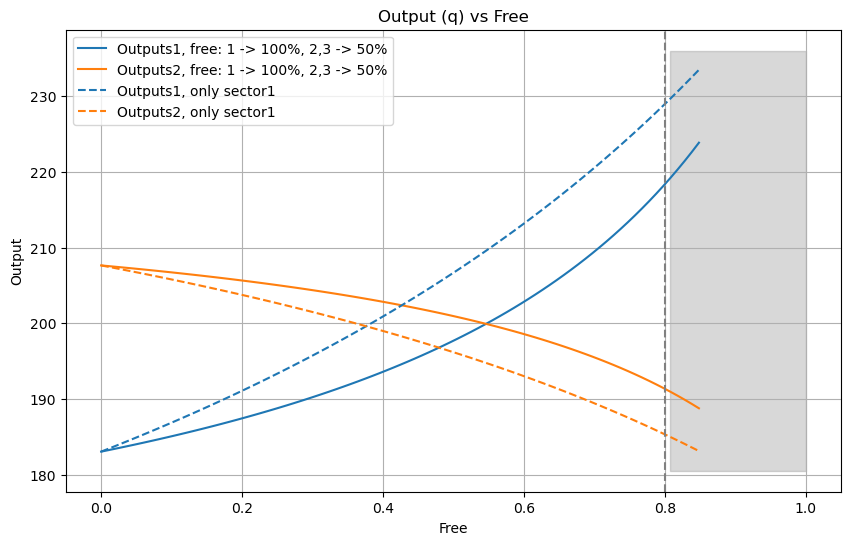

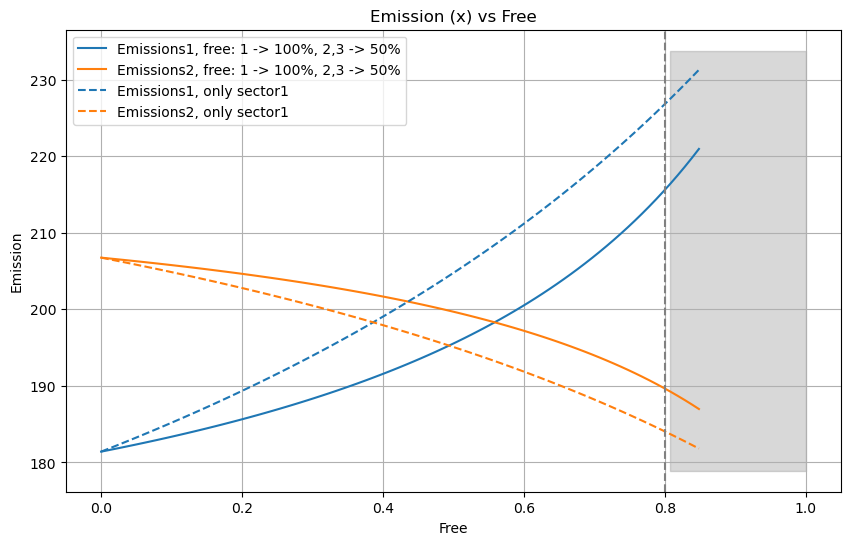

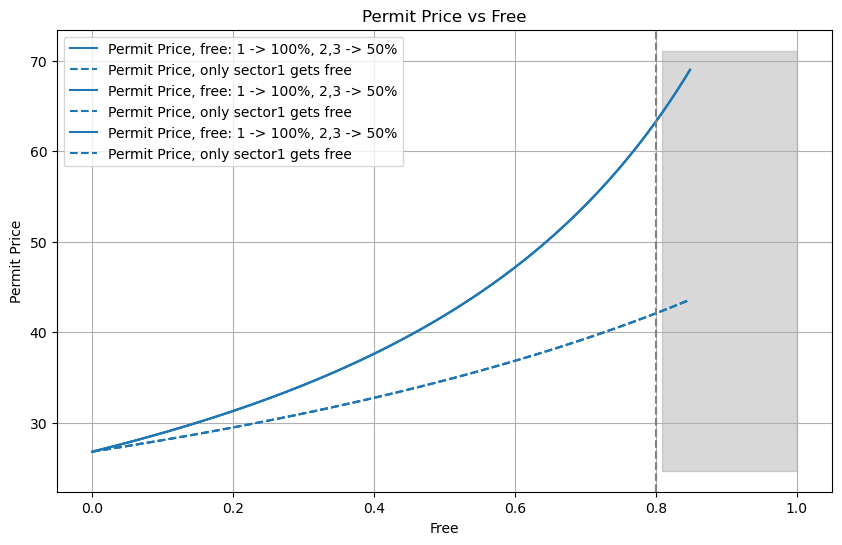

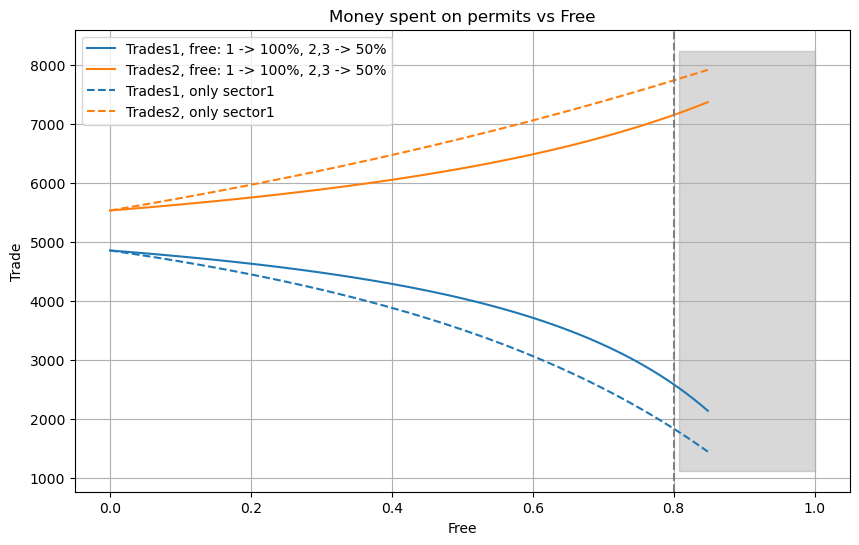

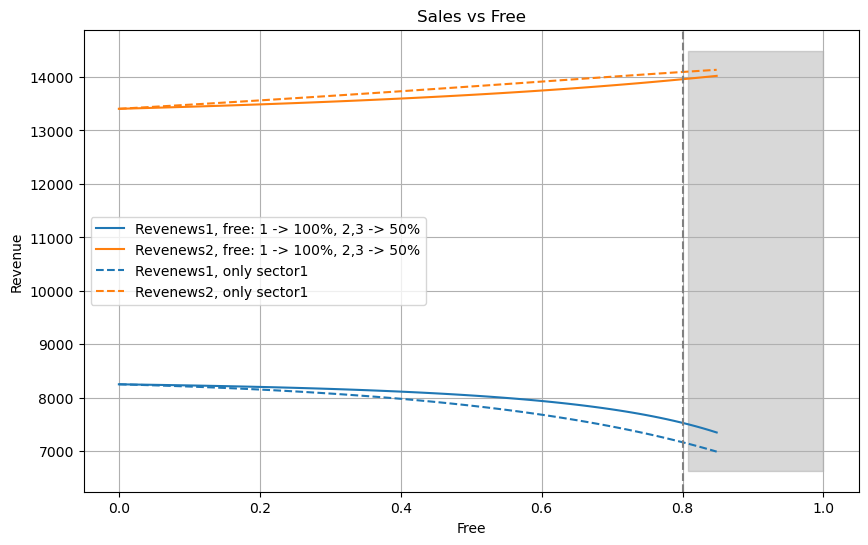

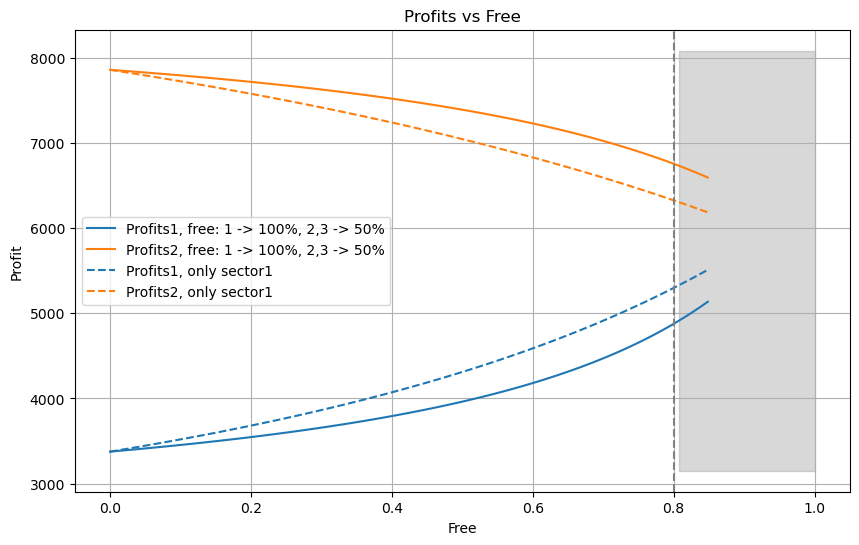

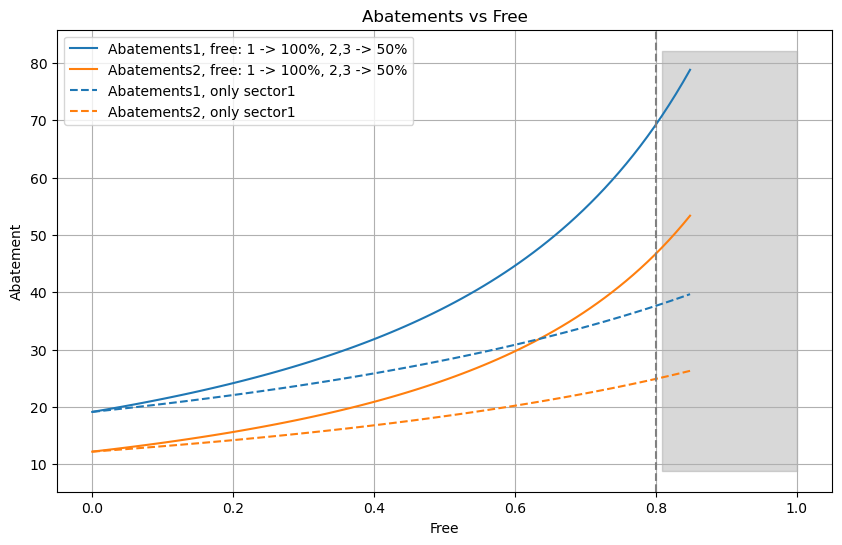

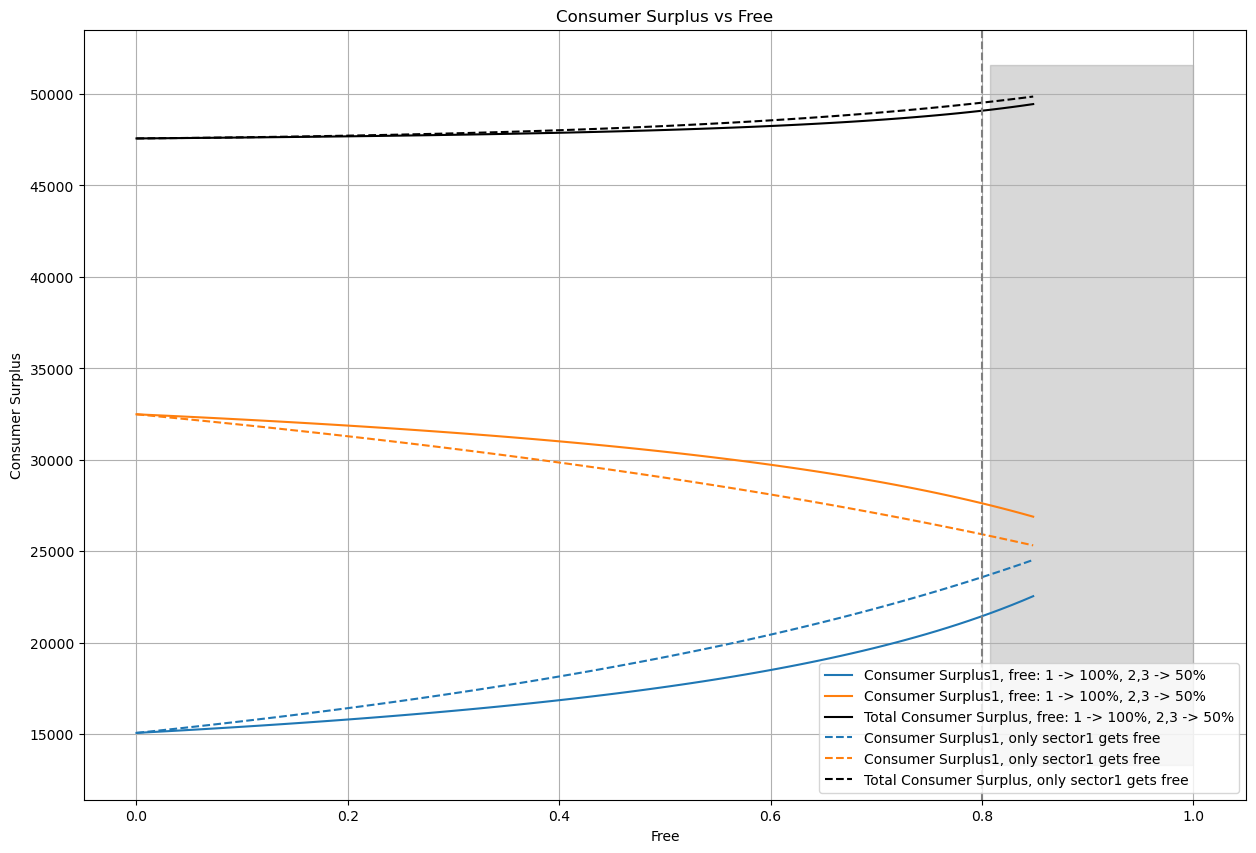

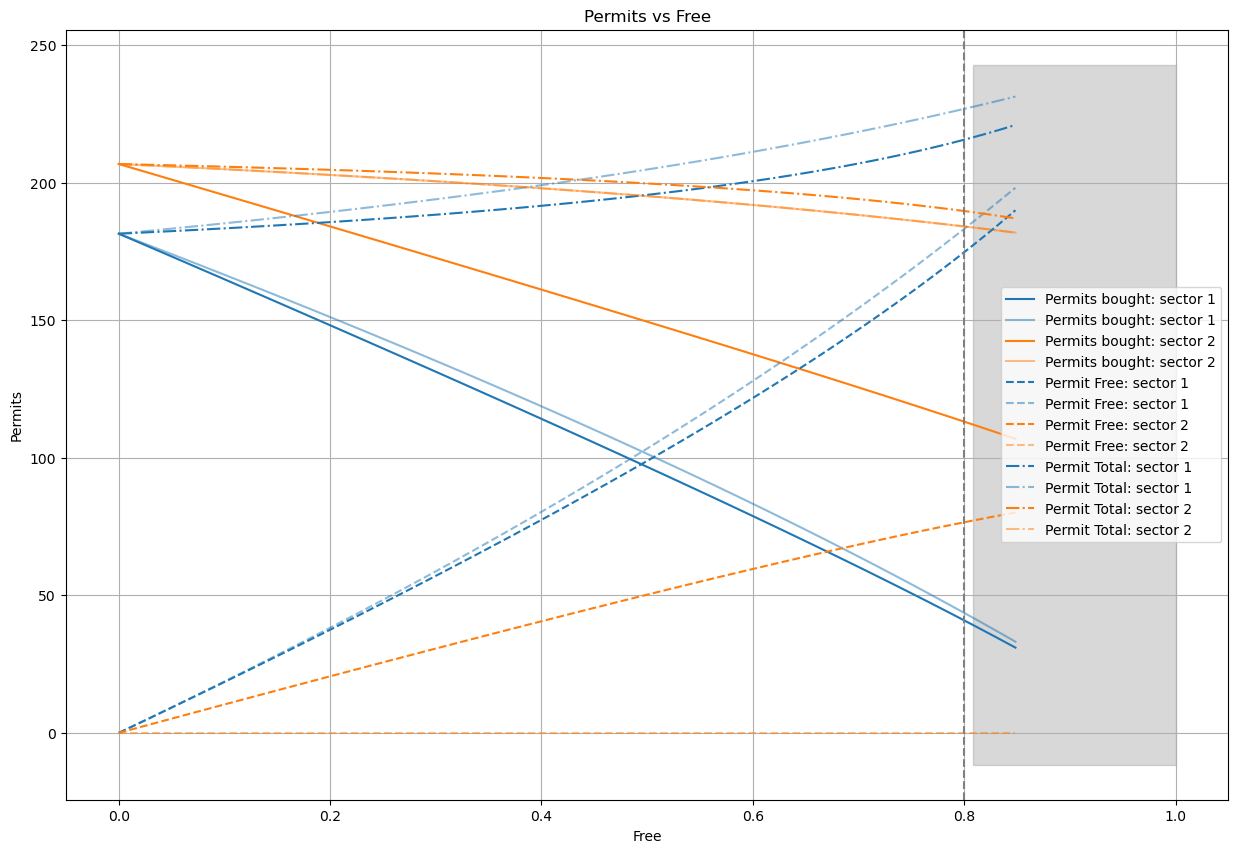

In [6]:
percentage_of_emission_cap = Regulator25.emission_cap / Regulator25.BAU_emissions
first_value = 0
last_value = 85
# Define colors and transparency levels
colors = {'trades1': '#1f77b4', 'trades2': '#ff7f0e'}


# Define a function to plot the metrics
def plot_metric(metric, ylabel, title):
    plt.figure(figsize=(10, 6))
    plt.plot(frees[first_value:last_value] , results[True][f'{metric}1'][first_value:last_value], label=f'{metric.capitalize()}1, free: 1 -> 100%, 2,3 -> 50%', color=colors['trades1'])
    plt.plot(frees[first_value:last_value], results[True][f'{metric}2'][first_value:last_value], label=f'{metric.capitalize()}2, free: 1 -> 100%, 2,3 -> 50%', color=colors['trades2'])
    plt.plot(frees[first_value:last_value], results[False][f'{metric}1'][first_value:last_value], label=f'{metric.capitalize()}1, only sector1', color=colors['trades1'], linestyle='--')
    plt.plot(frees[first_value:last_value], results[False][f'{metric}2'][first_value:last_value], label=f'{metric.capitalize()}2, only sector1', color=colors['trades2'], linestyle='--')
    plt.axvline(x=percentage_of_emission_cap, color='grey', linestyle='--')
    plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees > percentage_of_emission_cap), color='grey', alpha=0.3)
    plt.xlabel('Free')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Plot consumer surplus


# Plot outputs
plot_metric('outputs', 'Output', 'Output (q) vs Free')

# Plot emissions
plot_metric('emissions', 'Emission', 'Emission (x) vs Free')

# Plot permit prices
plt.figure(figsize=(10, 6))
for do in [0.7, 0.8, 0.9]:
    plt.plot(frees[first_value:last_value], results[True]['permit_price'][first_value:last_value], label=f'Permit Price, free: 1 -> 100%, 2,3 -> 50%', color=colors['trades1'])
    plt.plot(frees[first_value:last_value], results[False]['permit_price'][first_value:last_value], label=f'Permit Price, only sector1 gets free', color=colors['trades1'], linestyle='--')
plt.axvline(x=percentage_of_emission_cap, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees > percentage_of_emission_cap), color='grey', alpha=0.3)
plt.xlabel('Free')
plt.ylabel('Permit Price')
plt.title('Permit Price vs Free')
plt.legend()
plt.grid()
plt.show()

# Plot trades
plot_metric('trades', 'Trade', 'Money spent on permits vs Free')

# Plot revenues
plot_metric('revenews', 'Revenue', 'Sales vs Free')



# Plot profits
plot_metric('profits', 'Profit', 'Profits vs Free')

# Plot abatements
plot_metric('abatements', 'Abatement', 'Abatements vs Free')


from operator import add
plt.figure(figsize=(15, 10))
plt.plot(frees[first_value:last_value], results[True]['consumer_surplus_1'][first_value:last_value], label=f'Consumer Surplus1, free: 1 -> 100%, 2,3 -> 50%', color=colors['trades1'])
plt.plot(frees[first_value:last_value], results[True]['consumer_surplus_2'][first_value:last_value], label=f'Consumer Surplus1, free: 1 -> 100%, 2,3 -> 50%', color=colors['trades2'])
plt.plot(frees[first_value:last_value], list( map(add,results[True]['consumer_surplus_1'], results[True]['consumer_surplus_2']))[first_value:last_value], label=f'Total Consumer Surplus, free: 1 -> 100%, 2,3 -> 50%', color='black')
plt.plot(frees[first_value:last_value], results[False]['consumer_surplus_1'][first_value:last_value], label=f'Consumer Surplus1, only sector1 gets free', color=colors['trades1'], linestyle='--')
plt.plot(frees[first_value:last_value], results[False]['consumer_surplus_2'][first_value:last_value], label=f'Consumer Surplus1, only sector1 gets free', color=colors['trades2'], linestyle='--')
plt.plot(frees[first_value:last_value], list( map(add,results[False]['consumer_surplus_1'], results[False]['consumer_surplus_2']))[first_value:last_value], label=f'Total Consumer Surplus, only sector1 gets free', color='black', linestyle='--')
plt.axvline(x=percentage_of_emission_cap, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees > percentage_of_emission_cap), color='grey', alpha=0.3)
plt.xlabel('Free')
plt.ylabel('Consumer Surplus')
plt.title('Consumer Surplus vs Free')
plt.legend()
plt.grid()
plt.show()

# Plot permits bought, free, and used for each doentage
alphas = {True: 1, False: 0.5}
colors = {'b': '#1f77b4', 'o': '#ff7f0e'}
plt.figure(figsize=(15, 10))
for do in [True, False]: plt.plot(frees[first_value:last_value], results[do]['permits_bought_1'][first_value:last_value], label=f'Permits bought: sector 1', color=colors['b'], alpha=alphas[do])
for do in [True, False]:plt.plot(frees[first_value:last_value], results[do]['permits_bought_2'][first_value:last_value], label=f'Permits bought: sector 2', color=colors['o'], alpha=alphas[do])
for do in [True, False]:plt.plot(frees[first_value:last_value], results[do]['permits_free_1'][first_value:last_value], label=f'Permit Free: sector 1', color=colors['b'], linestyle='--', alpha=alphas[do])
for do in [True, False]:plt.plot(frees[first_value:last_value], results[do]['permits_free_2'][first_value:last_value], label=f'Permit Free: sector 2', color=colors['o'], linestyle='--', alpha=alphas[do])
for do in [True, False]:plt.plot(frees[first_value:last_value], results[do]['permits_used_1'][first_value:last_value], label=f'Permit Total: sector 1', color=colors['b'], linestyle='-.', alpha=alphas[do])
for do in [True, False]:plt.plot(frees[first_value:last_value], results[do]['permits_used_2'][first_value:last_value], label=f'Permit Total: sector 2', color=colors['o'], linestyle='-.', alpha=alphas[do])
plt.axvline(x=percentage_of_emission_cap, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees > percentage_of_emission_cap), color='grey', alpha=0.3)
plt.xlabel('Free')
plt.ylabel('Permits')
plt.title('Permits vs Free')
plt.legend()
plt.grid()
plt.show()